In [1]:
import numpy as np
import sib_ldsc_z as ld
from scipy.optimize import minimize
from scipy.special import comb
from scipy.misc import derivative
import scipy.stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import glob
reload(ld)

<module 'sib_ldsc_z' from 'C:\\Users\\Hariharan\\Documents\\git_repos\\SNIPar\\ldsc_reg\\inferz\\sib_ldsc_z.py'>

# Defining the PDF and the Log Likelihoods

The likelihood for a SNP $i$ is:

$$
l_i = -\frac{d}{2} log (2 \pi) - \frac{1}{2} log ( |I + r_i S_i^{-1/2} V S_i^{-1/2}| ) - \frac{1}{2} z_i^T (I + r_i S_i^{-1/2} V S_i^{-1/2}) ^{-1} z_i
$$

And its derivative:

$$
\frac{dl}{dV} = r_i S^{-1/2} \Sigma_i^{-1} (\Sigma - z_i z_i^T) \Sigma_i^{-1} S^{-1/2}
$$

In [2]:
np.random.seed(123)

# N = int(100)
# S_size = int(N/2)
# S = np.array([np.array([[.5, 0], [0, .8]]),
#     np.array([[0.5, 0], [0, 0.8]])] * S_size )
# V = np.identity(2) * 0.5
# f = np.random.uniform(0, 1, N)

N = int(1e4)
S = np.array([[[1e-4, -5 * 1e-5], [-5 * 1e-5, 1e-4]]] * N)
V = np.array([[0.5, 0.25], [0.25, 0.5]])

In [3]:
model = ld.sibreg(S = S)
model.simdata(V/N, N, simr = True)

Warning there is no value for z. Maybe consider simulating it
No value for U given. Generating a vector of ones (all SNPs weighted equally)
No value for r given. Generating a vector of ones for r
Simulated LD scores!
Effect Vectors Simulated!


In [4]:
Vin = ld.extract_upper_triangle(V)
model.neg_logll_grad(Vin)

-38631.03860184949, [[0.5  0.25]
 [0.25 0.5 ]]


(38631.03860184949, array([-140.90639708,  -82.11590935,  125.08515464]))

In [5]:
# Testing derivatives
aderiv = model._grad_ll_v(V, model.z[0, :], model.S[0],  model.r[0])

nderiv = model._num_grad_V(V, model.z[0, :], model.S[0],  model.r[0])

np.allclose(aderiv, nderiv)

True

In [6]:
# solving
output, result = model.solve() #), gradfunc = model._num_grad_V
print(result)

No initial guess provided.
Making 'optimal' matrix
-53885.63883263604, [[1.e-06 0.e+00]
 [0.e+00 1.e-06]]
-39174.91113085404, [[0.59828088 0.55097349]
 [0.55097349 0.58179941]]
-39075.68463881357, [[0.60889756 0.53379927]
 [0.53379927 0.59148168]]
-38874.593261680006, [[0.64220394 0.47313802]
 [0.47313802 0.6182262 ]]
-38817.423705512934, [[0.65891829 0.43603959]
 [0.43603959 0.62745011]]
-38784.86161289391, [[0.6711916  0.40092216]
 [0.40092216 0.62909792]]
-38761.81093709159, [[0.67820015 0.36661315]
 [0.36661315 0.62322344]]
-38733.76991520625, [[0.67970455 0.30918831]
 [0.30918831 0.60363174]]
-38714.2543860015, [[0.66103192 0.23610379]
 [0.23610379 0.5696433 ]]
-38699.979418211406, [[0.6164181  0.19464524]
 [0.19464524 0.54090087]]
-38655.96400716245, [[0.54127437 0.2035464 ]
 [0.2035464  0.50564764]]
-38629.63701458618, [[0.50291681 0.26571183]
 [0.26571183 0.47456159]]
-38627.567327699704, [[0.52405994 0.26039677]
 [0.26039677 0.48626418]]
-38627.523595919534, [[0.52258617 0.262

In [7]:
output

array([[0.52261778, 0.26207497],
       [0.26207497, 0.48484062]])

In [8]:
modll = model._log_ll(V, model.z[0, :], model.S[0], model.r[0])

In [9]:
V_norm = V
S_inv_root = ld.calc_inv_root(model.S[0])
dist = scipy.stats.multivariate_normal(mean = None,
                                      cov = np.eye(V.shape[0]) + model.r[0] * S_inv_root @ V_norm @ S_inv_root)

nlogll = dist.logpdf(model.z[0, :])
print(nlogll)

-11.68651716929529


In [10]:
modll

-11.68651716929529

# Playing with Derivatives

In [11]:
def alogll_grad(V, S=model.S):
    
    d = S[0].shape[0]
    log_ll = 0
    Gvec = np.zeros((d, d))
    N = len(S)
    V_norm = V/N
    
    for i in range(N):
        Si = S[i]
        zi = model.z[i, :].reshape((d, 1))
        ui = model.u[i]
        ri = model.r[i]
#         Si = N * Si 


        log_ll += (1/ui) * model._log_ll(V_norm , zi, Si, ri)
        Gvec += (1/ui) * model._grad_ll_v(V_norm, zi, Si, ri)
        
    return -log_ll, -Gvec/(N)

In [12]:
def snorm_logll_grad(V, S=model.S):
    
    # gradient calcualted by using S=S*N but
    # not using G = G/N
    
    d = S[0].shape[0]
    log_ll = 0
    Gvec = np.zeros((d, d))
    N = len(S)
    V_norm = V#/N
    
    for i in range(N):
        Si = S[i]
        zi = model.z[i, :].reshape((d, 1))
        ui = model.u[i]
        ri = model.r[i]
        Si = N * Si 


        log_ll += (1/ui) * model._log_ll(V_norm , zi, Si, ri)
        Gvec += (1/ui) * model._grad_ll_v(V_norm, zi, Si, ri)
        
    return -log_ll, -Gvec#/(N)

In [13]:
def nderiv(V, grad_func):
    
    g = np.zeros(V.shape)
    for i in range(0,V.shape[0]):
        for j in range(0,V.shape[1]):
            dV = np.zeros((V.shape))
            dV[i,j] = 10 ** (-6)
            V_upper = V+dV
            V_lower = V-dV
            g[i,j] = (grad_func(V_upper)[0] - \
                      grad_func(V_lower)[0]) / (2 * 10 ** (-6))
    return g


In [14]:
ajac = alogll_grad(V)[1]
print(ajac)

[[-140.90639708  -82.11590935]
 [ -82.11590935  125.08515464]]


In [15]:
njac = nderiv(V, alogll_grad)
print(njac)

[[-140.90638797  -82.11585373]
 [ -82.11585373  125.08519285]]


In [16]:
np.allclose(njac, ajac)

True

In [17]:
njac = nderiv(V, snorm_logll_grad)
print(njac)

[[-140.90638797  -82.11585373]
 [ -82.11585373  125.08518921]]


In [18]:
ajac = snorm_logll_grad(V)[1]
print(ajac)

[[-140.90639708  -82.11590935]
 [ -82.11590935  125.08515464]]


# Comparing Z's of Causal SNPs and Small Sim

In [19]:
# Reading file
files = glob.glob("C:/Users/Hariharan/Documents/genoecon_work/snipardata/causal.hdf5")
print("Reading files...")

# read in first file
file = files[0]
print("Reading file: ", file)
hf = h5py.File(file, 'r')
theta  = hf.get('estimate')[()]
S = hf.get('estimate_covariance')[()]
f = hf.get('freqs')[()]

if len(files) > 1:
    for file in files[1:]:
        print("Reading file: ", file)
        hf = h5py.File(file, 'r')
        theta_file  = hf.get('estimate')[()] 
        S_file = hf.get('estimate_covariance')[()]
        f_file = hf.get('freqs')[()]

        theta = np.append(theta, theta_file, axis = 0)
        S = np.append(S, S_file, axis = 0)
        f = np.append(f, f_file, axis = 0)
  

N = theta.shape[0]

print("S matrix:", S)
print("Theta Matrix: ", theta)
print("Initiating Model...")

# == Keeping only direct effects == #
# S = S[:,0 ,0].reshape((S.shape[0], 1, 1))
# theta = theta[:, 0].reshape((theta.shape[0], 1))

# == amplifying direct effects == #
# Sdir = np.empty(len(S))
# for i in range(len(S)):
#   Sdir[i] = np.array([[1.0, 0.5, 0.5]]) @ S[i] @ np.array([1.0, 0.5, 0.5]).T

# S = Sdir.reshape((len(S), 1, 1))
# theta = theta @ np.array([1.0, 0.5, 0.5])
# theta = theta.reshape((theta.shape[0], 1))


# calcualting z
z = np.empty_like(theta)
z[:] = np.nan
for i in range(z.shape[0]):
    z[i, :] = ld.calc_inv_root(S[i]) @ theta[i, :].T
    
print("Z: ", z)

Reading files...
Reading file:  C:/Users/Hariharan/Documents/genoecon_work/snipardata/causal.hdf5
S matrix: [[[ 2.49708974e-04 -1.78184186e-04 -1.28097367e-04]
  [-1.78184186e-04  9.47441498e-04 -5.13250765e-04]
  [-1.28097367e-04 -5.13250765e-04  8.28836346e-04]]

 [[ 3.28004273e-04 -2.32643710e-04 -1.72544300e-04]
  [-2.32643710e-04  1.22006156e-03 -6.53659808e-04]
  [-1.72544300e-04 -6.53659808e-04  1.07297208e-03]]

 [[ 5.27196098e-04 -3.77260410e-04 -2.80475797e-04]
  [-3.77260410e-04  1.98145583e-03 -1.07192912e-03]
  [-2.80475797e-04 -1.07192912e-03  1.77837047e-03]]

 ...

 [[ 6.16542675e-05  1.31975798e-06 -1.13049909e-05]
  [ 1.31975798e-06  5.47293923e-04 -1.85105309e-04]
  [-1.13049909e-05 -1.85105309e-04  3.47601832e-04]]

 [[ 2.30412261e-04  1.88402828e-05 -4.37237904e-05]
  [ 1.88402828e-05  1.63058180e-03 -1.14203047e-03]
  [-4.37237904e-05 -1.14203047e-03  1.44876423e-03]]

 [[ 2.96793558e-04  2.50526136e-05 -9.40222435e-06]
  [ 2.50526136e-05  4.27673076e-04 -3.644169

C:\Users\Hariharan\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in matmul


Z:  [[ 1.71489615  1.82660698  0.10959741]
 [ 0.34703161 -1.13714521 -1.01209088]
 [ 1.91884219  0.63348112  1.95858415]
 ...
 [-0.01531185  1.75799714 -1.30650548]
 [-1.33615231  0.27179428 -2.55667539]
 [-0.25655738  1.96755749  2.15679972]]


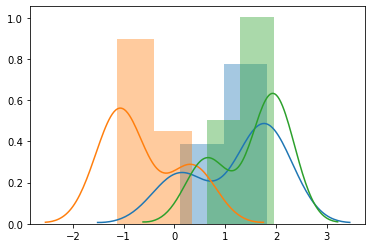

In [20]:
sns.distplot(z[0, :])
sns.distplot(z[1, :])
sns.distplot(z[2, :])